In [106]:
## IMPORTANT: COPY PADDLER LOCATIONS FROM LONGITUDINAL ANALYSIS CASES FOR EACH PADDLER
import _canoeValues as cv

pad_weights = cv.pad_weights
LLF = 1.3
DLF = cv.DLF # Dead Load Factor

mesh_thickness = cv.mesh_thickness

# Position of paddlers with respect to left end of canoe (mm)

pad_po = [1150, 2400, 3530, 4550]

# Rib Positions (mm)
rib_po = [1140, 1785, 2525, 3125, 3865, 4510]
rib_width, rib_height = 50, 100 # mm
rib_moment = [0 for _ in rib_po]

# Choose between pad_weights
paddler_weight = [pad_weights[2] * LLF, pad_weights[3] * LLF, pad_weights[3] * LLF, pad_weights[0] * LLF]

In [107]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#-----------inputs--------------------
outer_file = "Outer Hull.csv"
concrete_density = cv.concrete_density # Concrete density = 1200 kg/m^3
concrete_thickness = cv.concrete_thickness
compressive_strength = cv.compressive_strength
#-------------------------------------

# mm over 2, 3, 4, 6 paddlers
grasshopper = cv.grasshopper[2]

script_dir = os.path.abspath('data') # absolute file path in Jupyter

# Read the outer hull coordinates (ONLY USE OUTER HULL FOR TRANSVERSE)
file_path = os.path.join(script_dir, outer_file) # file path for the text file input
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

file_path = os.path.join(script_dir, "Station Information.csv") # file path for the text file input
canoe_info = pd.read_csv(file_path, header=None)
globalStationLength = float(canoe_info[4][22])

yung_modulus_concrete = 4500 * math.sqrt(compressive_strength)
yung_modulus_mesh = 72500 # MPa

N = yung_modulus_mesh / yung_modulus_concrete

def calculate_ybar_and_I(ybar_mesh, conc_thickness, conc_length):
    
    area_mesh = mesh_thickness * conc_length # mm^2
    area_equi_concrete = (N-1) * area_mesh
    
    cross_sectional_area_of_concrete = conc_thickness * conc_length
    ybar_concrete = conc_thickness/2
    
    ybar_top = (ybar_mesh * area_equi_concrete + ybar_concrete * cross_sectional_area_of_concrete) / (area_equi_concrete + cross_sectional_area_of_concrete) # mm
    ybar_bottom = conc_thickness - ybar_top
    I = (conc_length * conc_thickness**3 /12) + ((conc_thickness * conc_length) * (ybar_top-ybar_concrete)**2) + (area_equi_concrete * (ybar_mesh-ybar_top)**2)
    
    return ybar_top, ybar_bottom, I

def calculate_ybar_and_I_preceding_rib(ybar_mesh, conc_thickness, conc_length, rib_thickness, rib_length):
    
    area_mesh = mesh_thickness * conc_length # mm^2
    area_equi_concrete = (N-1) * area_mesh
    
    cross_sectional_area_of_concrete = conc_thickness * conc_length
    cross_sectional_area_of_rib = rib_thickness * rib_length
    
    ybar_concrete = conc_thickness/2
    ybar_rib = rib_thickness/2 + conc_thickness
    
    ybar_mesh_bottom = conc_thickness - ybar_mesh
    ybar_bottom = (ybar_mesh_bottom * area_equi_concrete + ybar_concrete * cross_sectional_area_of_concrete + ybar_rib * cross_sectional_area_of_rib) / (area_equi_concrete + cross_sectional_area_of_concrete + cross_sectional_area_of_rib) # mm
    ybar_top = conc_thickness + rib_thickness - ybar_bottom
    
    I = (conc_length * conc_thickness**3 /12) + (rib_length * rib_thickness**3 /12) + ((conc_thickness * conc_length) * (ybar_bottom-ybar_concrete)**2) + ((rib_thickness * rib_length) * (ybar_bottom-ybar_rib)**2) + (area_equi_concrete * (ybar_mesh_bottom-ybar_bottom)**2)
    
    return ybar_top, ybar_bottom, I

canoe_ybar_top, canoe_ybar_bottom, canoe_I = calculate_ybar_and_I(cv.d_mesh_1, concrete_thickness, globalStationLength)



print(canoe_I)


6605.5211894634685


11
23
34
45
Pos: [1140, 1785, 2525, 3125, 3865, 4510] 
Divisions: [0, 1462.5, 2155.0, 2825.0, 3495.0, 4187.5, 5650] 
Tributaries: [1462.5, 692.5, 670.0, 670.0, 692.5, 1462.5]
Rib moments (Nm): [-52.57366717042422, 18.53655612893683, -82.74452640267265, -10.952651249401399, -34.09197716107931, -23.76216398104669]
Rib Stress Top (MPa): [-0.3101472715094654, 0.11784995090431458, -0.5282624699828566, -0.06992456000911644, -0.21674672505062828, -0.14017987940601673]
Rib Stress Bottom (MPa): [0.06000833057190626, -0.0384867898334856, 0.17635034468469, 0.023342979977232056, 0.07078395527625475, 0.027122471534203]


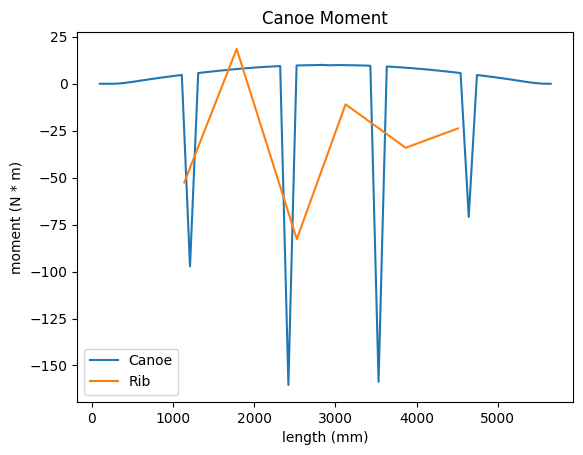

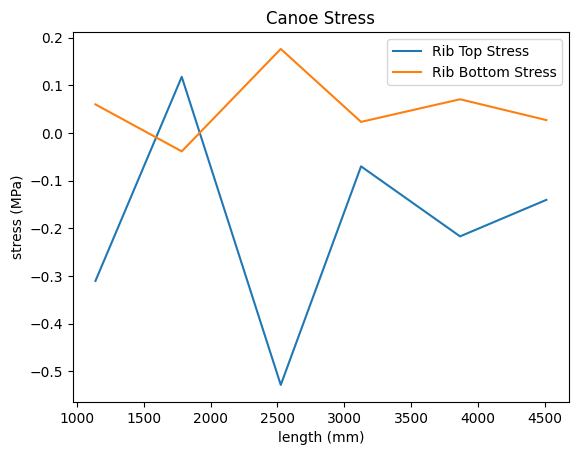

Resistance Top: 18221.645787353962 N*m
Resistance Bottom: 26121.681880600136 N*m


In [108]:
# Outer Hull Volume: Assume station is filled up with concrete
station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

currentLength = 0
nextPaddler = 0
nextRib = 0

stress_top = []
stress_bottom = []

resistance_top = []
resistance_bottom = []

station_moments = []

printCrossSectionYOut = []
printCrossSectionZOut = []
printCrossSectionCOMPAREYOut = []
printCrossSectionCOMPAREZOut = []

# Loop through each station
for k in range(0,station_no-1,1):

    # Coordinates of points in the outer frame sharing an X-coordinate with the current station
    X1_value = station[k]
    Y1 = []
    Z1 = []

    # Coordinates of points in the outer frame sharing an X-coordinate with the next station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each x coordinate in the outer hull
    for i in range(0,len(x_out),1):

        if(y_out[i] < 0):
            continue

        # If the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
            if k == math.floor(station_no-1 / 2):
                printCrossSectionYOut.append(y_out[i])
                printCrossSectionZOut.append(z_out[i])
            # Compare a station dist to middle
            # Still x_in - only care about the location at inner hull width


        # Otherwise, if the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

    # Calculate length, width, depth and waterline of this station
    station_length = (X2_value - X1_value) # mm
    station_width = max(Y1) # mm
    station_depth = abs(min(Z1)) # mm
    waterline = max(station_depth - grasshopper, 0) # mm

    moment_arm1 = station_width - concrete_thickness/2 # mm
    moment_arm2 = station_width/2 # mm
    self_weight1 = concrete_thickness * station_depth * station_length * concrete_density / 10**9 * 9.81 * DLF  # N
    self_weight2 = concrete_thickness * station_width * station_length * concrete_density / 10**9 * 9.81 * DLF # N

    #                              ----------pressure--------- * --------------area---------------
    horizontal_hydrostatic_force = 1000/10**9 * 9.81 * waterline / 2 * waterline * station_length # N
    horizontal_hydrostatic_distance = waterline / 3 # mm

    vertical_hydrostatic_force = 1000/10**9 * 9.81 * waterline * station_width * station_length # N
    vertical_hydrostatic_distance = station_width / 2 # mm

    # Determine if a paddler is in this station
    current_paddler_weight = 0
    prevLength = currentLength
    currentLength += station_length
    if pad_po[nextPaddler] >= prevLength and pad_po[nextPaddler] < currentLength:
        current_paddler_weight = paddler_weight[nextPaddler]
        print(k)
        if(nextPaddler < len(pad_po) - 1):
            nextPaddler += 1
            
    moment_arm_paddler = station_width / 2 # mm
    current_paddler_weight *= 9.81 # N
    
    moment = (horizontal_hydrostatic_force * horizontal_hydrostatic_distance + vertical_hydrostatic_force * vertical_hydrostatic_distance - self_weight1 * moment_arm1 - self_weight2 * moment_arm2 - current_paddler_weight * moment_arm_paddler) / 1000 # N*m
    
    # Check to see if we have passed to the next set of ribs
    if nextRib != len(rib_po) and rib_po[nextRib] < currentLength:
        nextRib += 1
    
    # Split the moment between the two surrounding ribs as a ratio of distance
    if nextRib == 0:
        rib_moment[0] += moment 
    elif nextRib == len(rib_po):
        rib_moment[-1] += moment
    else:
        ratio = (rib_po[nextRib] - currentLength) / (rib_po[nextRib] - rib_po[nextRib-1])
        
        rib_moment[nextRib-1] += ratio * moment
        rib_moment[nextRib] += (1-ratio) * moment
        
    stress_top.append(moment*1000*canoe_ybar_top/canoe_I) # N/mm^2 (MPa)
    stress_bottom.append(-moment*1000*canoe_ybar_bottom/canoe_I) # N/mm^2 (MPa)

    resistance_top.append(compressive_strength * canoe_I / canoe_ybar_top) # N*mm
    resistance_bottom.append(compressive_strength * canoe_I / canoe_ybar_bottom)  # N*mm
    
    station_moments.append(moment)

stress_top_rib = []
stress_bottom_rib = []

ribDivisions = [0] + [abs(ribPo1 + ribPo2) / 2 for ribPo1, ribPo2 in zip(rib_po, rib_po[1:])] + [round(globalStationLength * (station_no-1))]
ribTributaries = [abs(ribDiv1 - ribDiv2) for ribDiv1, ribDiv2 in zip(ribDivisions, ribDivisions[1:])]

print("Pos:", rib_po, "\nDivisions:", ribDivisions, "\nTributaries:", ribTributaries)

for i in range(len(rib_po)):
    
    rib_ybar_top, rib_ybar_bottom, rib_I = calculate_ybar_and_I_preceding_rib(cv.d_mesh_1, concrete_thickness, ribTributaries[i], rib_height, rib_width)
    
    stress_top_rib.append(rib_moment[i]*1000*rib_ybar_top/rib_I) # N/mm^2 (MPa)
    stress_bottom_rib.append(-rib_moment[i]*1000*rib_ybar_bottom/rib_I) # N/mm^2 (MPa)

print("Rib moments (Nm):", rib_moment)
print("Rib Stress Top (MPa):", stress_top_rib)
print("Rib Stress Bottom (MPa):", stress_bottom_rib)

plt.plot(station[1:57], station_moments, label="Canoe")
plt.plot(rib_po, rib_moment, label="Rib")
plt.title('Canoe Moment')
plt.xlabel('length (mm)')
plt.ylabel('moment (N * m)')
plt.legend()
plt.show()

plt.plot(rib_po, stress_top_rib, label="Rib Top Stress")
plt.plot(rib_po, stress_bottom_rib, label="Rib Bottom Stress")
plt.title('Canoe Stress')
plt.xlabel('length (mm)')
plt.ylabel('stress (MPa)')
plt.legend()
plt.show()

print("Resistance Top:", resistance_top[23], "N*m")
print("Resistance Bottom:", resistance_bottom[23], "N*m")


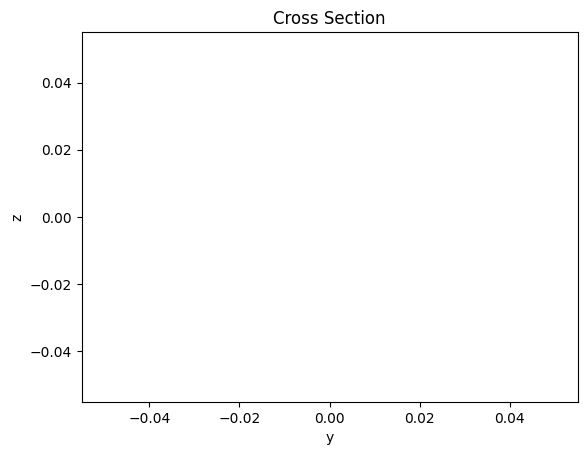

In [109]:
plt.plot(printCrossSectionYOut, printCrossSectionZOut)
plt.plot(printCrossSectionCOMPAREYOut, printCrossSectionCOMPAREZOut)
plt.title('Cross Section')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

# for i in range(len(printCrossSectionYIn)):
#     print(printCrossSectionYIn[i] - printCrossSectionYOut[i], printCrossSectionZIn[i] - printCrossSectionZOut[i])